# 0.0 Import Libraries

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb

import math 
import inflection
import datetime

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy

from scipy                 import stats as ss

# 0.1 Load Data

In [2]:
# reading data
df_sales_raw = pd.read_csv ( '../data/train.csv', low_memory= False )
df_store_raw = pd.read_csv ( '../data/store.csv', low_memory= False )

# merging datasets
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 0.2 Functions

In [3]:
# rename columns to snakecase style
def rename_columns(dataframe):
    df = dataframe.copy()

    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new
    
    return df

# returns cramer´s v
def cramer_v( x, y ):
    # create confunsion matrix 
    cm = pd.crosstab( x, y ).values

    # sum of confusion matrix
    n = cm.sum()

    # confusion matrix - rows and cols
    r, k = cm.shape

    # calculate chi2
    chi2 = ss.chi2_contingency( cm )[0]    

    # calculate adjusted chi2, k, r
    chi2_adj = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_adj = k - (k-1)**2/(n-1)
    r_adj = r - (r-1)**2/(n-1)

    # calculate and return cramer´s v
    return np.sqrt( ( chi2_adj/n ) / ( min( k_adj-1, r_adj-1) ) )    

def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE'        : mae,
                           'MAPE'       : mape,
                           'RMSE'       : rmse
                           }, index=[0] )


# 1.0 Descriptive Data Analysis

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
df1 = rename_columns( df1 )
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [6]:
print(f'Number of Rows: { df1.shape[0] }' )
print(f'Number of Cols: { df1.shape[1] }' )

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [7]:
# list data types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
# number of rows with NA values by column
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
# competition_distance 
# competition_distance with NA values means "no competitor around". 
# Set max value mutiplied by 3 in the null rows

max_value = df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: max_value*3 if math.isnan( x ) else x )

print(f'Old Max Value of competition distance: { max_value } ' )
print(f'New Max Value of competition distance: { df1["competition_distance"].max() } ' )


Old Max Value of competition distance: 75860.0 
New Max Value of competition distance: 227580.0 


In [11]:
# competition_open_since_month and competition_open_since_year 
# Set month and year of sale as default value

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
df1['competition_open_since_year']  = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] )   else x['competition_open_since_year'], axis=1 )

In [12]:
# promo2_since_week  and promo2_since_year
# Set month and year of sale as default value

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [13]:
# promo_interval  

# first, create a new column(month_map) with the month of sale  
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df1['promo_interval'].fillna( 0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )

# second, create a new column(is_promo) to check two conditions:  if promo_interval is active (1) and if month_map is inside promo_interval. (0) No, (1) Yes
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) 


df1.sample(5).T

,317953,432597,231195,227282,855716
store,278,763,391,938,182
day_of_week,7,1,1,5,6
date,2014-10-05 00:00:00,2014-06-09 00:00:00,2015-01-05 00:00:00,2015-01-09 00:00:00,2013-05-25 00:00:00
sales,0,0,8797,8872,4233
customers,0,0,930,941,355
open,0,0,1,1,1
promo,0,0,1,1,0
state_holiday,0,a,0,0,0
school_holiday,0,0,1,0,0
store_type,a,d,a,a,d


## 1.6 Change Types

In [14]:
# change data types from float to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [15]:
# identify and separate numerical and categorical attrributes
df_num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
df_cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

df_cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
790292,0,c,a,0,Jul
341737,0,a,c,0,Sep


### 1.7.1 Numerical Attributes

In [16]:
# Central Tendency - mean, median
df_mean = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T

# Dispersion - min, max, range, std, skew, kurtosis
df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate dataframes
df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [17]:
df_cat_attributes.apply( lambda x: x.unique().shape[0] )


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

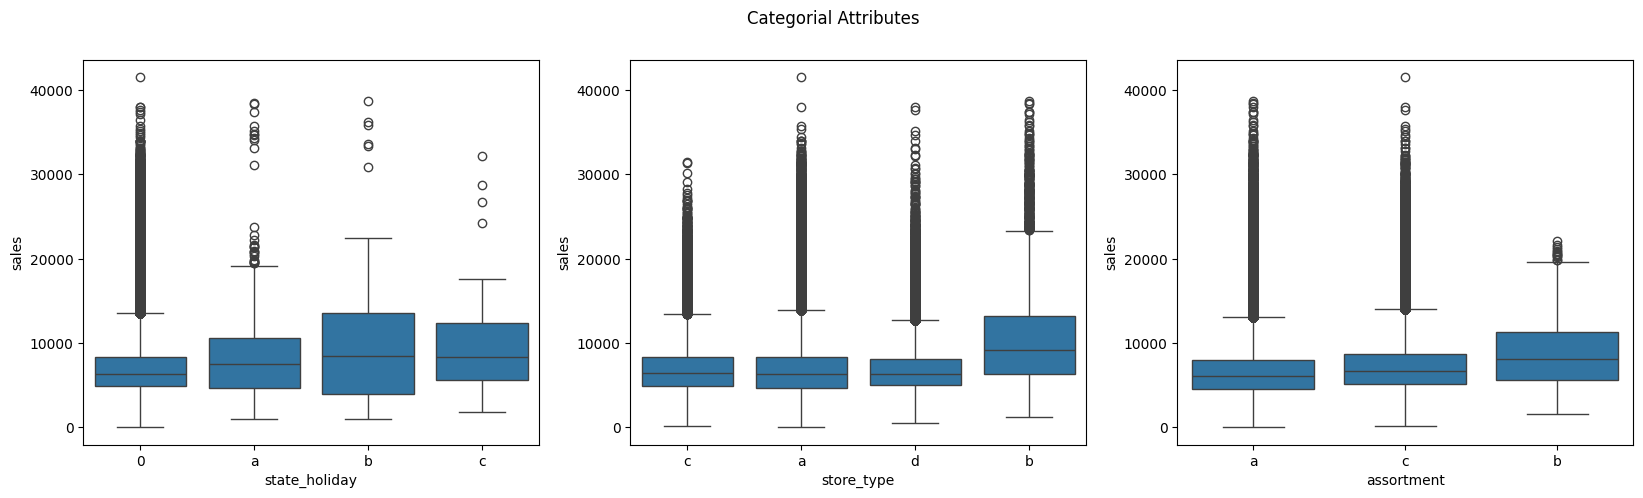

In [18]:
df1_aux = df1[ ( df1['state_holiday'] != 0 )  & ( df1['sales'] > 0 ) ]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Categorial Attributes')

sns.boxplot( ax=axes[0], x='state_holiday', y='sales', data=df1_aux );
sns.boxplot( ax=axes[1], x='store_type',    y='sales', data=df1_aux );
sns.boxplot( ax=axes[2], x='assortment',    y='sales', data=df1_aux );


# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 Hypothesis Mind Map

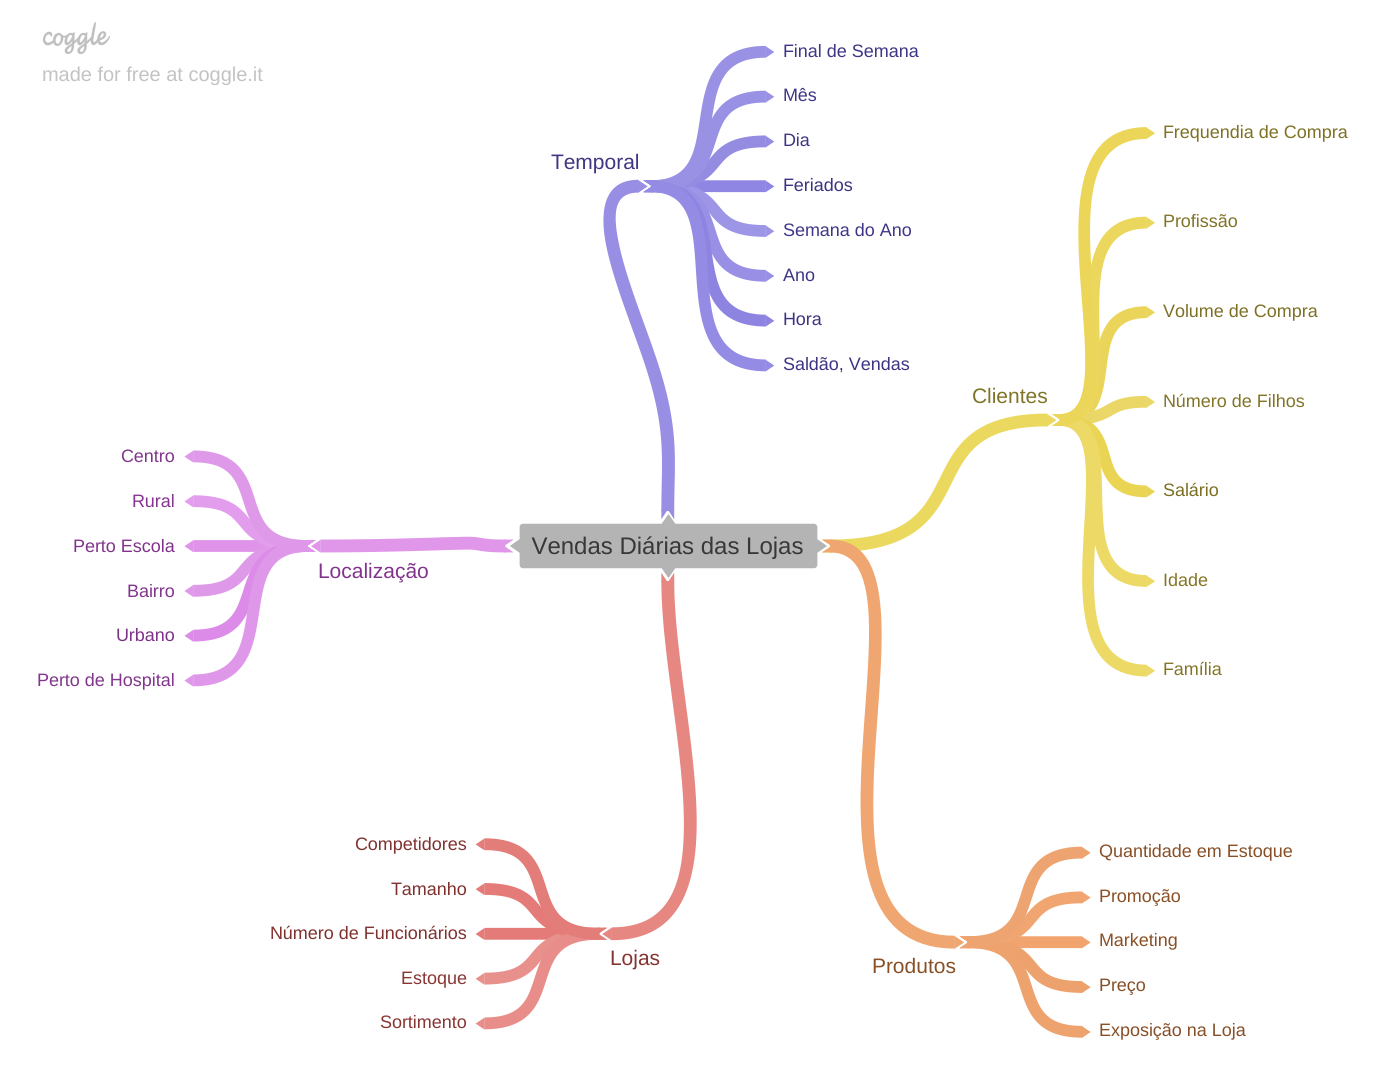

In [20]:
Image( '../img/mapa_de_hipoteses.png')

## 2.2 List of Hypotheses

### 2.2.1 Store Hypothesis

**1.** Lojas com maior número de funcionários deveriam vender mais 

**2.** Lojas com maior estoque deveriam vender mais 

**3.** Lojas de maior porte deveriam vender mais 

**4.** Lojas com maior sortimento deveriam vender mais 

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2 Product Hypothesis

**1.** Lojas com maior investimento em marketing deveriam vender mais

**2.** Lojas que expõem mais produtos na vitrine deveriam vender mais

**3.** Lojas com produtos com preço menores deveriam vender mais

**4.** Lojas com produtos com preço menores por mais tempo deveriam vender mais

**5.** Lojas com promoções mais agressivas deveriam vender mais

**6.** Lojas com promoções ativas a mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos nos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Priority List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais (STORE)

**2.** Lojas com competidores mais próximos deveriam vender menos (STORE)

**3.** Lojas com competidores a mais tempo deveriam vender mais (STORE)



**4.** Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)

**5.** Lojas com mais dias de promoção deveriam vender mais (PRODUCT)

**6.** Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)



**7.** Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**8.** Lojas deveriam vender mais ao longo dos anos (TIME)

**9.** Lojas deveriam vender mais no segundo semestre do ano (TIME)

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**11.** Lojas deveriam vender menos nos finais de semana (TIME)

**12.** Lojas deveriam vender menos durante os feriados escolares (TIME)




## 2.4 Create Features

### 2.4.1 From date column

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2.apply( lambda x: datetime.date( x['year'], x['month'], x['day'] ).isocalendar().week, axis=1 )

# year week
df2['year_week'] = df2.apply( lambda x: str( x['year'] ) + '-' + str( x['week_of_year'] ), axis=1 )

df2[['date', 'year', 'month', 'day', 'week_of_year', 'year_week']].sample(5)

,date,year,month,day,week_of_year,year_week
382782,2014-07-28,2014,7,28,31,2014-31
706788,2013-10-06,2013,10,6,40,2013-40
681478,2013-10-29,2013,10,29,44,2013-44
741814,2013-09-04,2013,9,4,36,2013-36
212133,2015-01-22,2015,1,22,4,2015-4


### 2.4.2 From competition_open_since columns

In [22]:
df2['competition_since']      = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = df2.apply( lambda x: ( ( x['date'] - x['competition_since'] ) / 30 ).days, axis=1 ).astype( int )

df2[['date', 'competition_open_since_year', 'competition_open_since_month', 'competition_since', 'competition_time_month']].sample(5)

,date,competition_open_since_year,competition_open_since_month,competition_since,competition_time_month
232228,2015-01-04,2015,1,2015-01-01,0
445348,2014-05-28,2008,9,2008-09-01,69
1016027,2013-01-02,2012,9,2012-09-01,4
542348,2014-03-02,2014,3,2014-03-01,0
651065,2013-11-25,2013,11,2013-11-01,0


### 2.4.3 From promo2_since columns

In [23]:
df2['promo2_since']     = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo2_since']     = df2['promo2_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo2_time_week'] = df2.apply( lambda x: ( ( x['date'] - x['promo2_since'] ) / 7 ).days, axis=1 ).astype( int )

df2[['promo2_since_year', 'promo2_since_week', 'promo2_since', 'date', 'promo2_time_week']].sample(5)

,promo2_since_year,promo2_since_week,promo2_since,date,promo2_time_week
194827,2010,35,2010-08-23,2015-02-07,232
889134,2013,17,2013-04-22,2013-04-25,0
497016,2013,5,2013-01-28,2014-04-12,62
16678,2011,14,2011-03-28,2015-07-17,224
515733,2013,10,2013-03-04,2014-03-26,55


### 2.4.4 From assorment column

In [24]:
#  describes an assortment level: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )
df2['assortment'].value_counts()

assortment
basic       537445
extended    471470
extra         8294
Name: count, dtype: int64

### 2.4.5 From state_holiday column

In [25]:
#StateHoliday - indicates a state holiday. 
#Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
#a = public holiday, b = easter holiday, c = christmas, 0 = regular day

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day' )
df2['state_holiday'].value_counts()


state_holiday
regular day       986159
public holiday     20260
easter holiday      6690
christmas           4100
Name: count, dtype: int64

## 2.5 Filtering Variables

### 2.5.1 Filtering Lines

In [26]:
# remove lines where there are no sales 
df2 = df2[ ( df2['open'] != 0 ) & ( df2['sales'] > 0 ) ]
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
864109,770,6,2013-05-18,4970,536,1,0,regular day,0,a,...,0,2013,5,18,20,2013-20,2015-04-01,-23,2013-05-13,0
271427,541,1,2014-11-24,9279,1084,1,1,regular day,0,a,...,0,2014,11,24,48,2014-48,1990-07-01,297,2014-11-24,0
184908,934,1,2015-02-16,5913,552,1,1,regular day,0,a,...,0,2015,2,16,8,2015-8,2015-02-01,0,2011-03-28,203
780525,811,4,2013-08-01,4701,793,1,1,regular day,1,a,...,0,2013,8,1,31,2013-31,2012-09-01,11,2013-07-29,0
249282,895,4,2014-12-18,13754,1122,1,1,regular day,0,a,...,0,2014,12,18,51,2014-51,2014-12-01,0,2014-12-15,0


### 2.5.2 Filtering Columns

In [27]:
# customers -> Quantidade de clientes nas lojas, não é possível saber quantos clientes estarão nas lojas na predição. 
# open -> Se a loja está aberta ou não. Quando está fechada não há vendas, ou seja, devem ser consideradas apenas as linhas com loja aberta ( open != 0 )
# sales -> Valor total em vendas. Quando não há vendas desconsiderar linhas ( sales > 0 )
# colunas que foram criadas apenas para auxiliar a geração de outras também devem ser excluídas. Ex: promo_interval, month_map

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df2 = df2.drop( cols_drop, axis=1 )
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo2_since', 'promo2_time_week'],
      dtype='object')

# 3.0 Exploratory Data Analysis

In [28]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

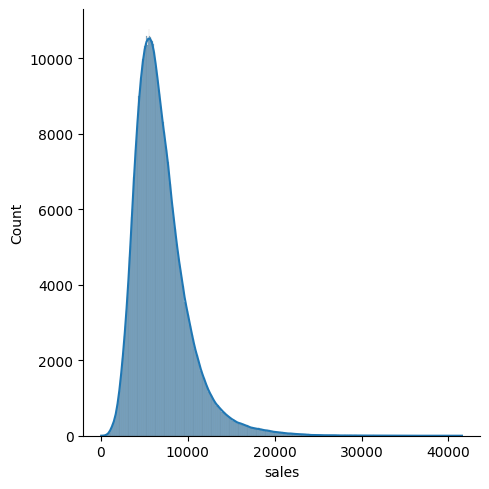

In [29]:
# checking distribuition 
sns.displot( df3['sales'], kde='hist');

### 3.1.2 Numerical Variables

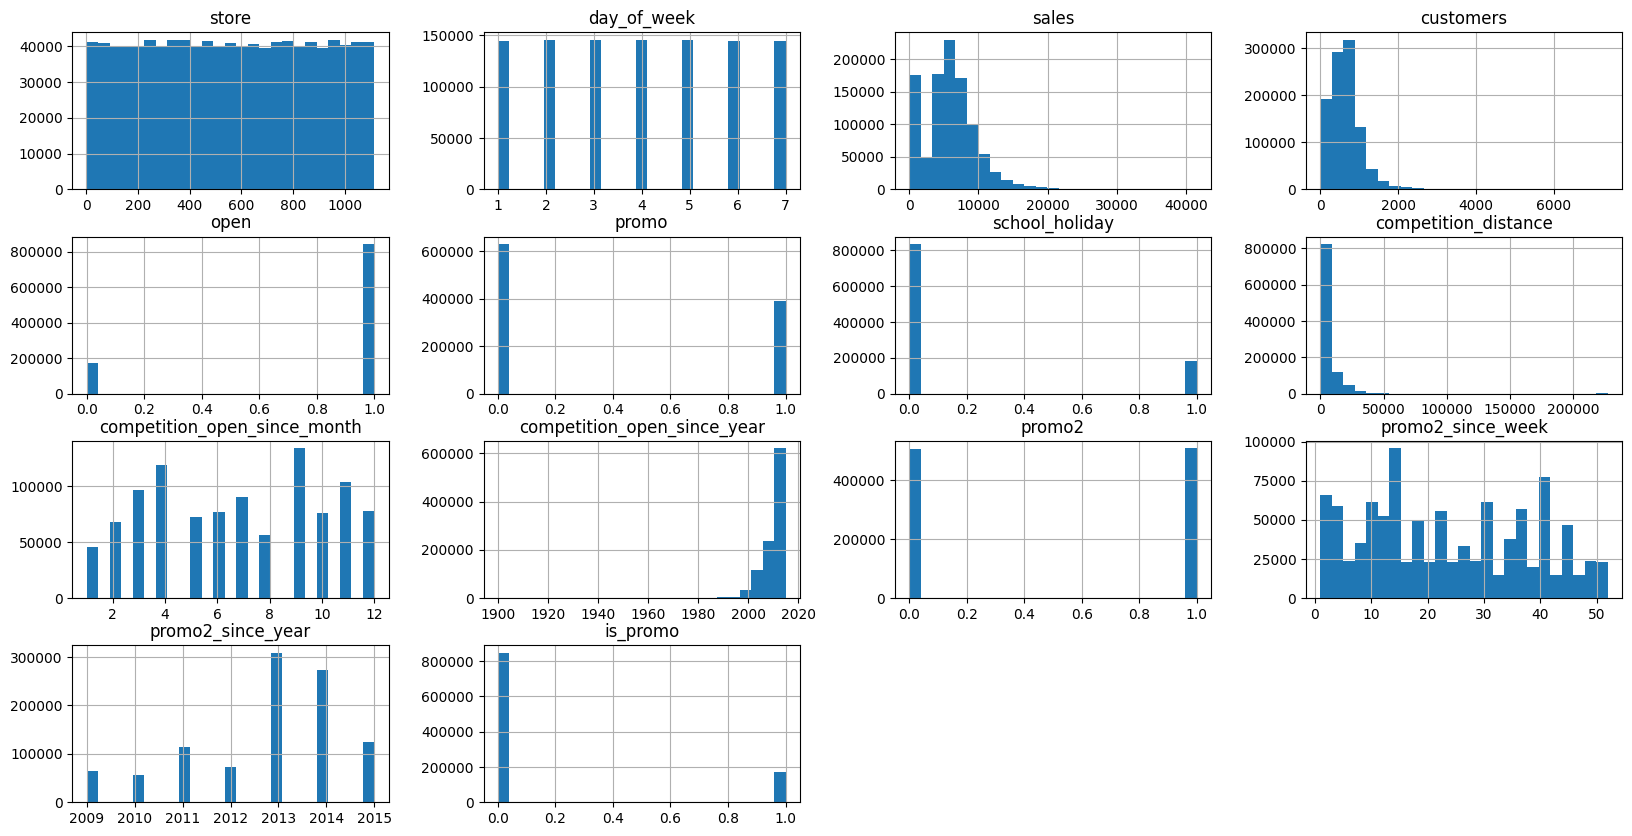

In [30]:
# cheking distribuition
df_num_attributes.hist( bins=25, figsize=(20, 10) );

##### Notas do gráfico: 

**1.** A variável "competition_open_since_month" apresenta vários comportamentos, e quantos mais comportamentos uma variável possui melhor para o aprendizado do modelo.

**2.** Já a variável "day_of_week" apresenta um comportamente constante, não há variação, esse tipo de variável sozinha não serve para o aprendizado modelo

### 3.1.3 Categorical Variables

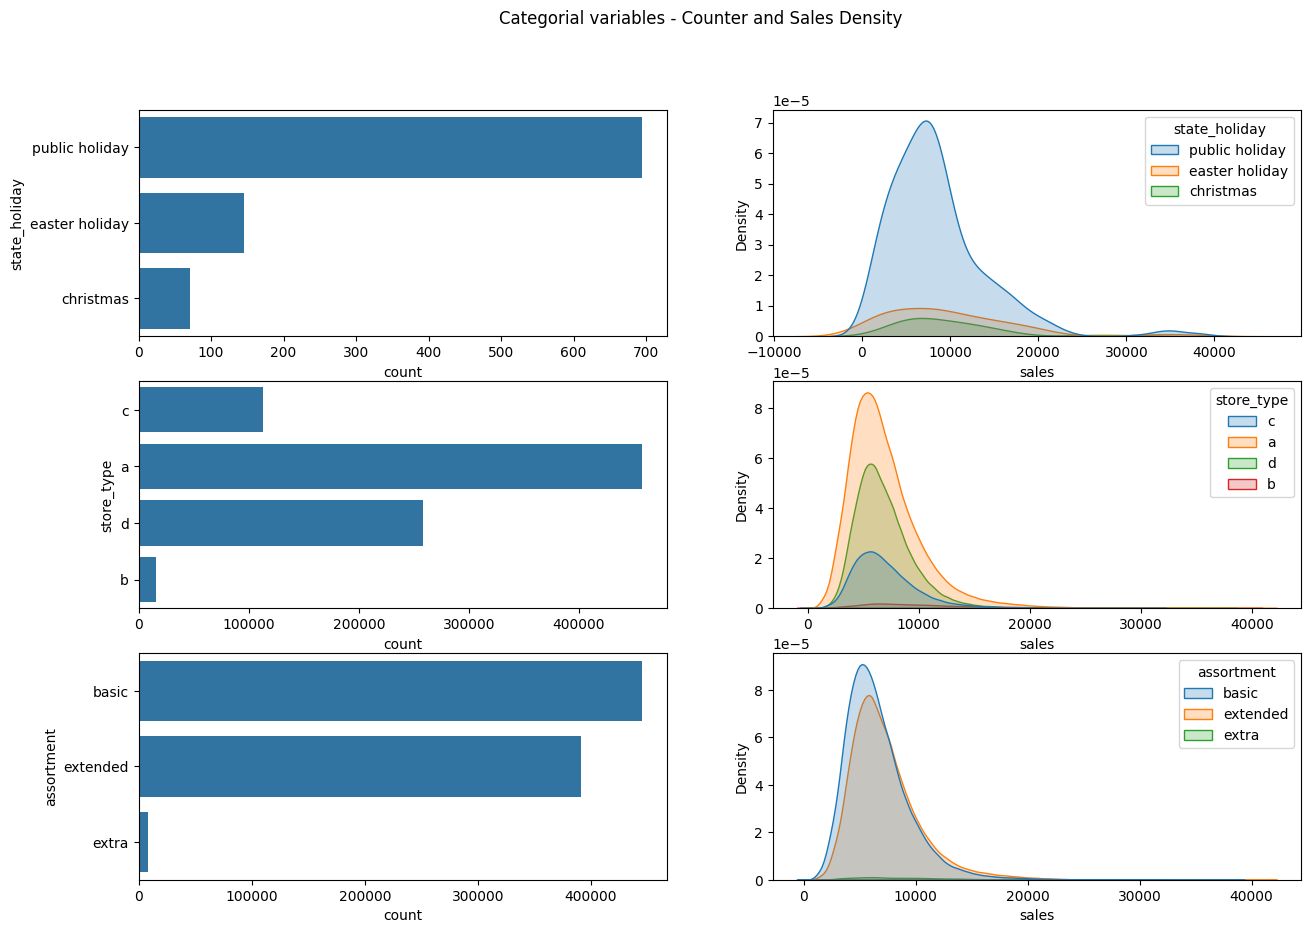

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Categorial variables - Counter and Sales Density')

# state_holiday
sns.countplot( ax=axes[0,0], data=df3[ df3['state_holiday'] !=  'regular day' ]['state_holiday'] );
sns.kdeplot  ( ax=axes[0,1], data=df3[ df3['state_holiday'] !=  'regular day' ][['state_holiday', 'sales']], x='sales',  hue='state_holiday', fill=True );

# store_type
sns.countplot( ax=axes[1,0], data=df3['store_type'] );
sns.kdeplot  ( ax=axes[1,1], data=df3[['store_type', 'sales']], x='sales',  hue='store_type', fill=True );

# assortment
sns.countplot( ax=axes[2,0], data=df3['assortment'] );
sns.kdeplot  ( ax=axes[2,1], data=df3[['assortment', 'sales']], x='sales',  hue='assortment', fill=True );


## 3.2 Bivariate Analysis

### H1 - Lojas com maior sortimento deveriam vender mais (STORE)

***FALSA*** Lojas com MAIOR SORTIMENTO vendem MENOS

***ASSORTMENT*** Apresenta comportamento variável na classe "extra", mas com um volume pequeno de dados, portanto, relevância BAIXA para o modelo

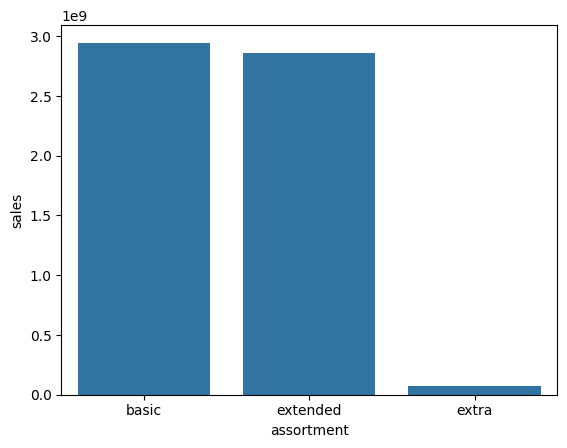

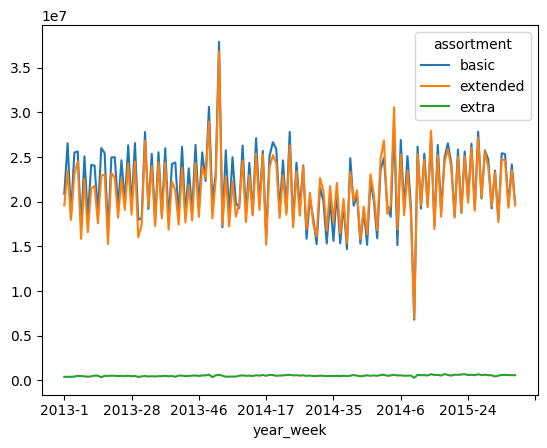

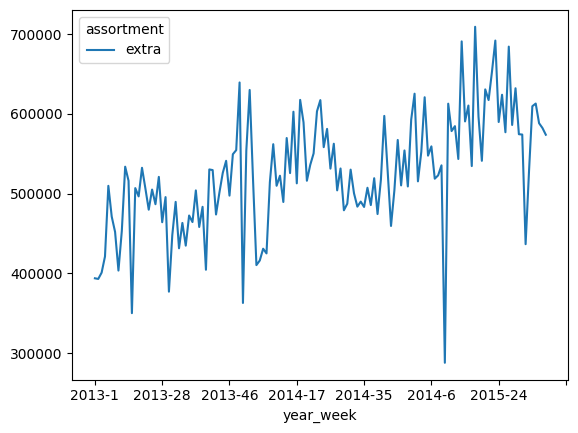

In [32]:
# sales x assortments - total
aux = df3[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux );

# sales x assortments - timeline 
aux2 = df3[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

# sales x assortments - only "extra" assortment
aux3 = aux2[ aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2 - Lojas com competidores mais próximos deveriam vender menos (STORE)

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

**COMPETITION_DISTANCE** apresenta uma correlação FRACA com a variável resposta

/tmp/ipykernel_1727/3322249751.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_km', 'sales']].groupby( 'competition_distance_km' ).sum().reset_index()


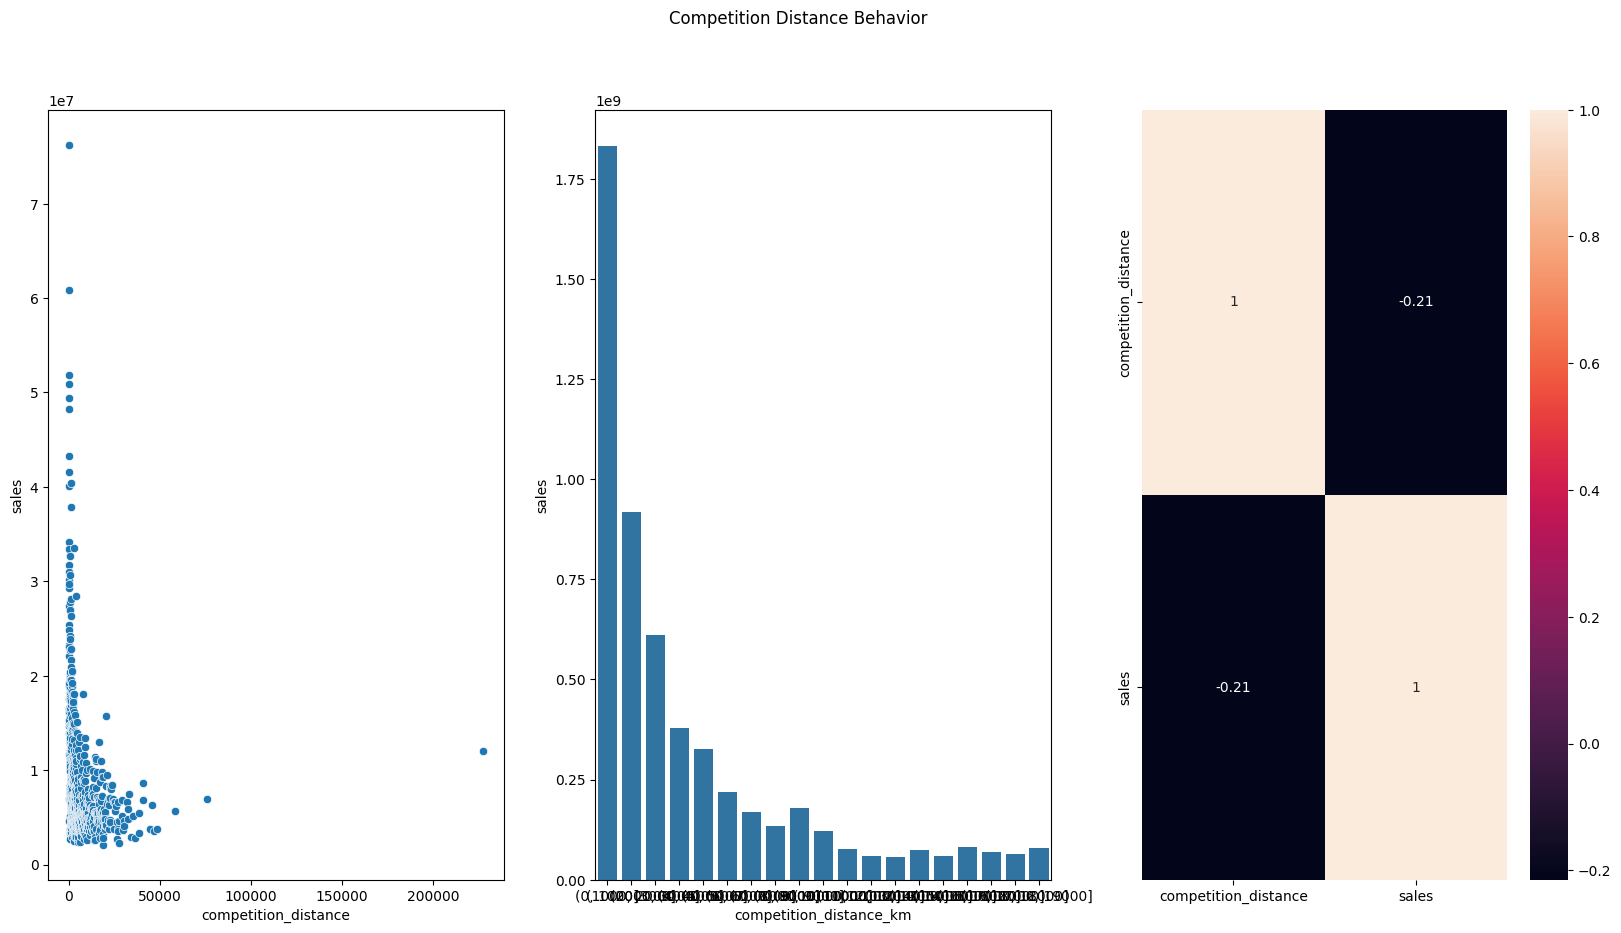

In [33]:

fig, axes = plt.subplots(1, 3, figsize=(20, 10) )
fig.suptitle('Competition Distance Behavior')


# sales x competition_distance - total
aux1 = df3[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( ax=axes[0], x='competition_distance', y='sales', data=aux1 );


# sales x competition_distance - grouped by km
competition_distance_km = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_km'] = pd.cut( aux1['competition_distance'], bins=competition_distance_km )
aux2 = aux1[['competition_distance_km', 'sales']].groupby( 'competition_distance_km' ).sum().reset_index()
sns.barplot( ax=axes[1], x='competition_distance_km', y='sales', data=aux2 );


# sales x competition_distance corr method
aux3 = aux1[['competition_distance', 'sales']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[2] );


### H3 - Lojas com competidores a mais tempo deveriam vender mais (STORE)



**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

**COMPETITION_TIME_MONTH** possui um correlação com a variável resposta muito próxima de ZERO, portanto, BAIXA CORRELAÇÃO

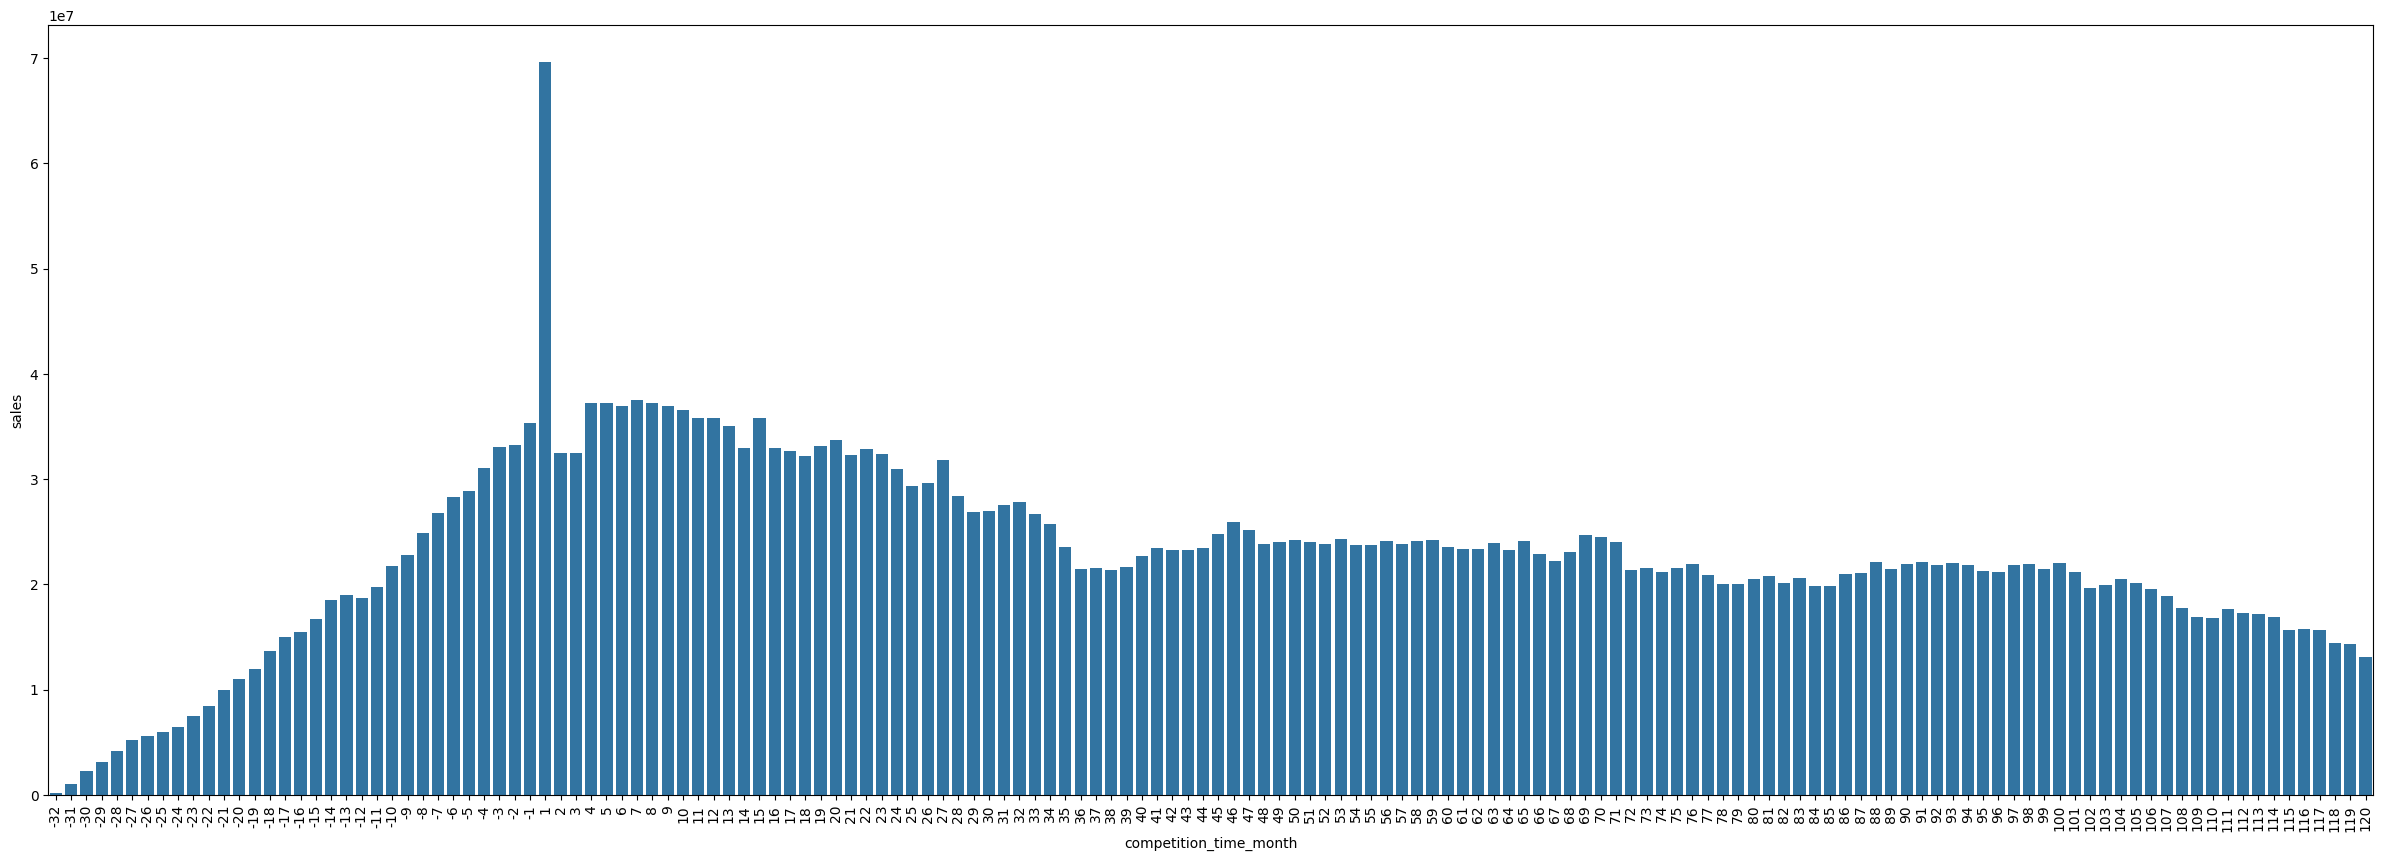

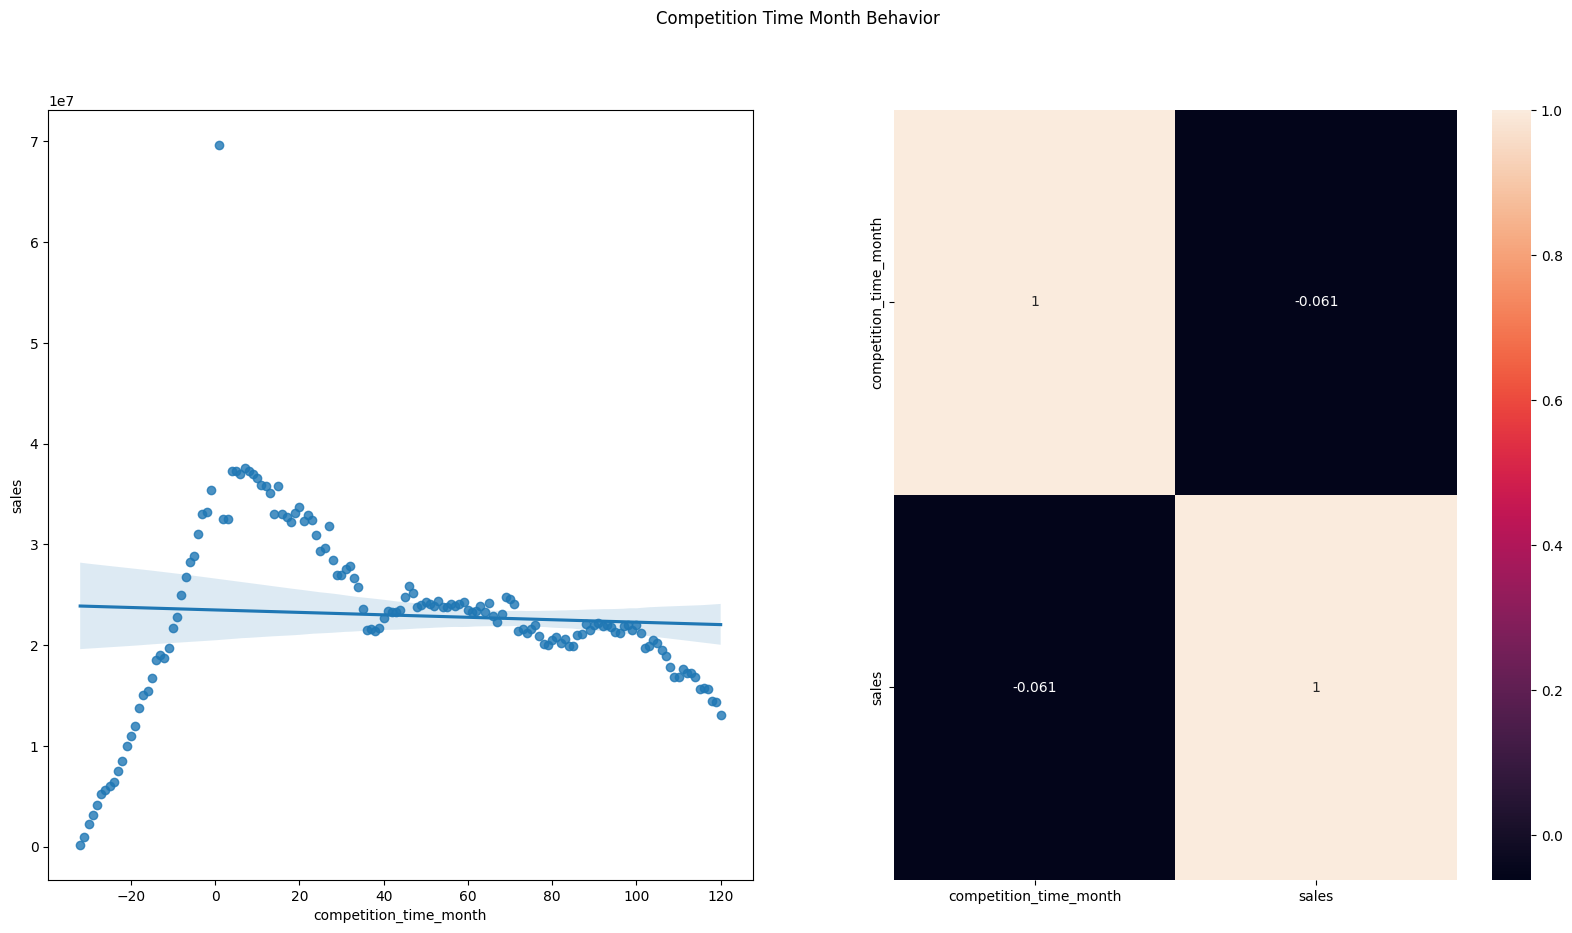

In [34]:
aux1 = df3[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux1 = aux1[ ( aux1['competition_time_month'] != 0 ) & ( aux1['competition_time_month'] <= 120 ) ]

plt.figure(figsize=(30,10));
plt.xticks( rotation='vertical');
sns.barplot( x='competition_time_month', y='sales', data=aux1 );

fig, axes = plt.subplots(1, 2, figsize=(20, 10) )
fig.suptitle('Competition Time Month Behavior')

# sales x competition_time_month 
sns.regplot( x='competition_time_month', y='sales', data=aux1, ax=axes[0] );

# sales x competition_distance corr method
sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axes[1] );


### H4 - Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)





**FALSA** Lojas com PROMOÇÔES ATIVAS A MAIS TEMPO vendem MENOS depois de um certo período de promoção

**PROMO2_TIME_WEEK** possui uma correlação FRACA com a variável resposta

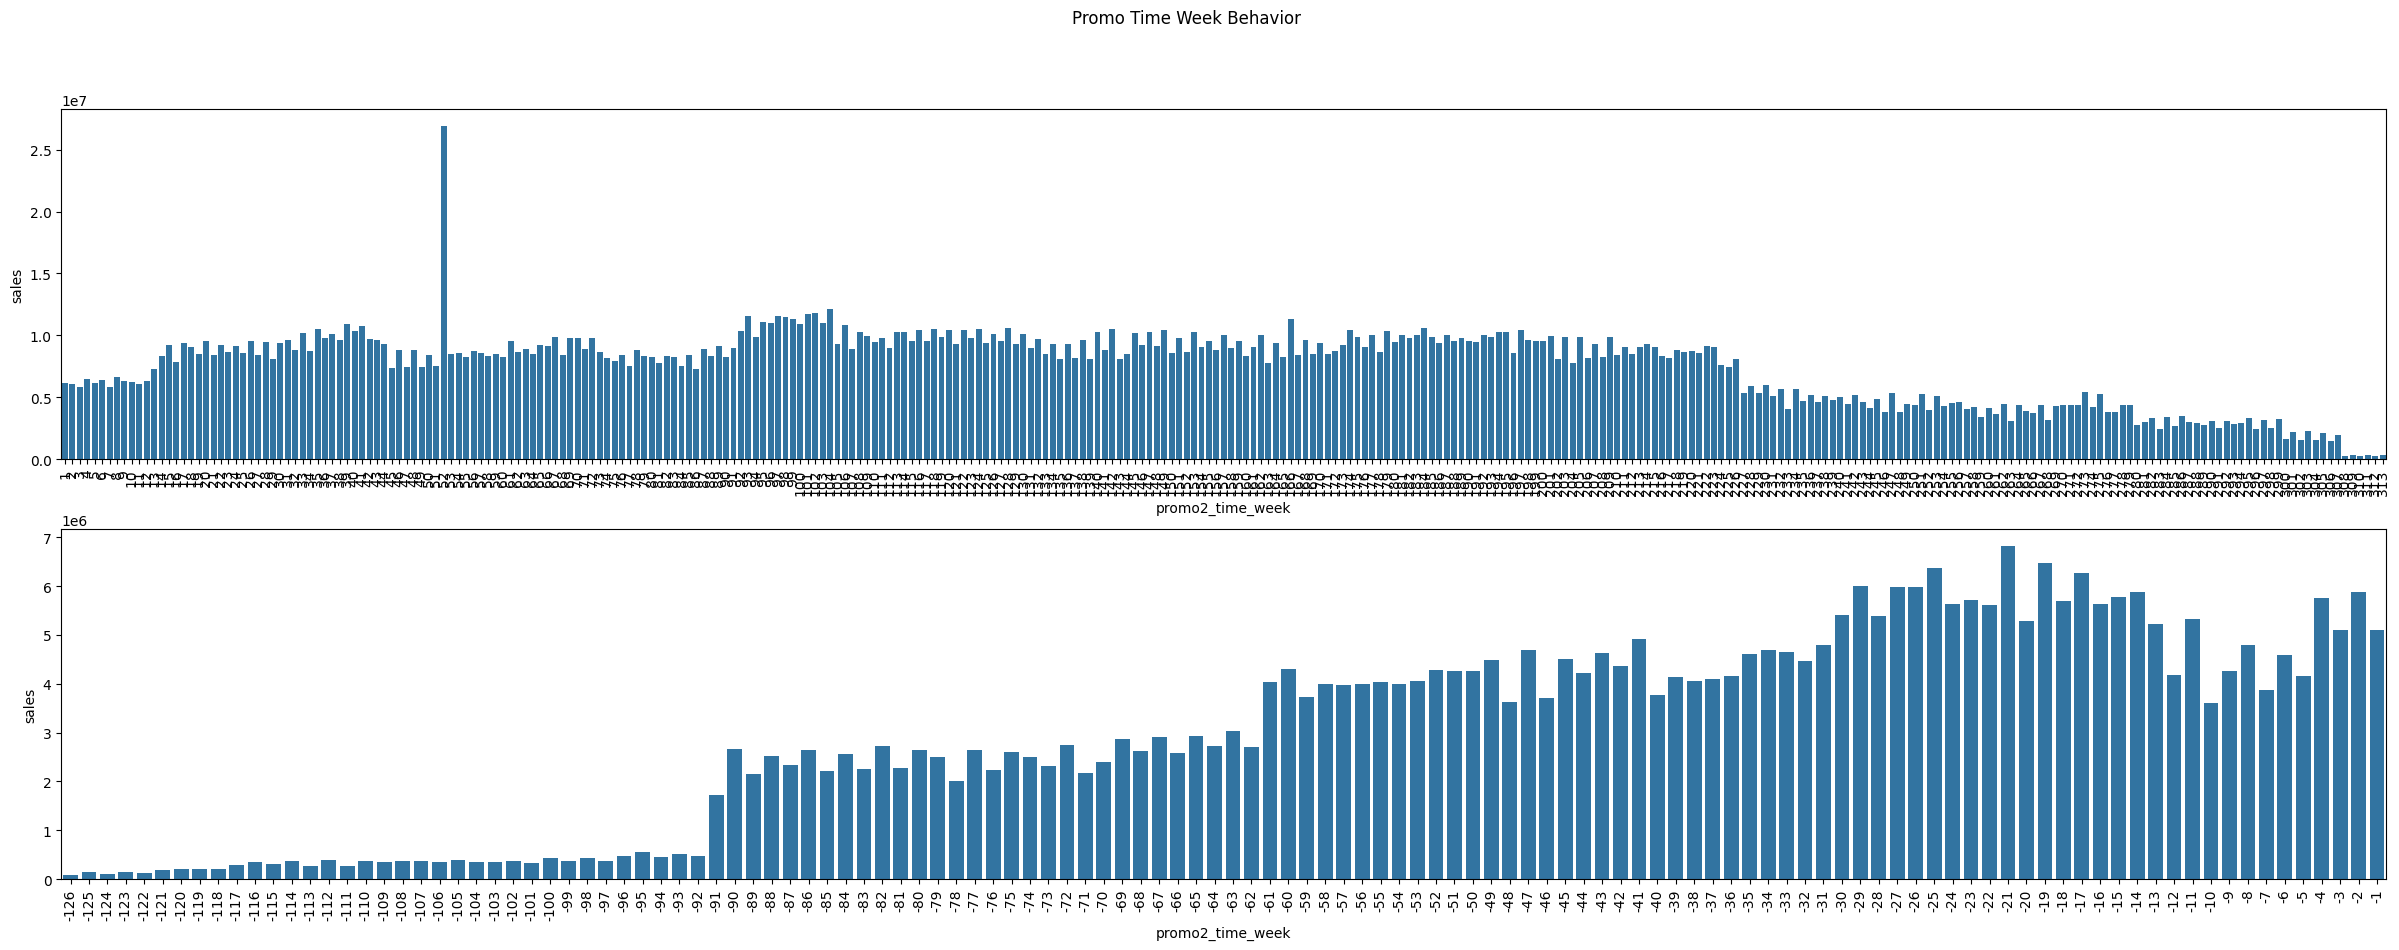

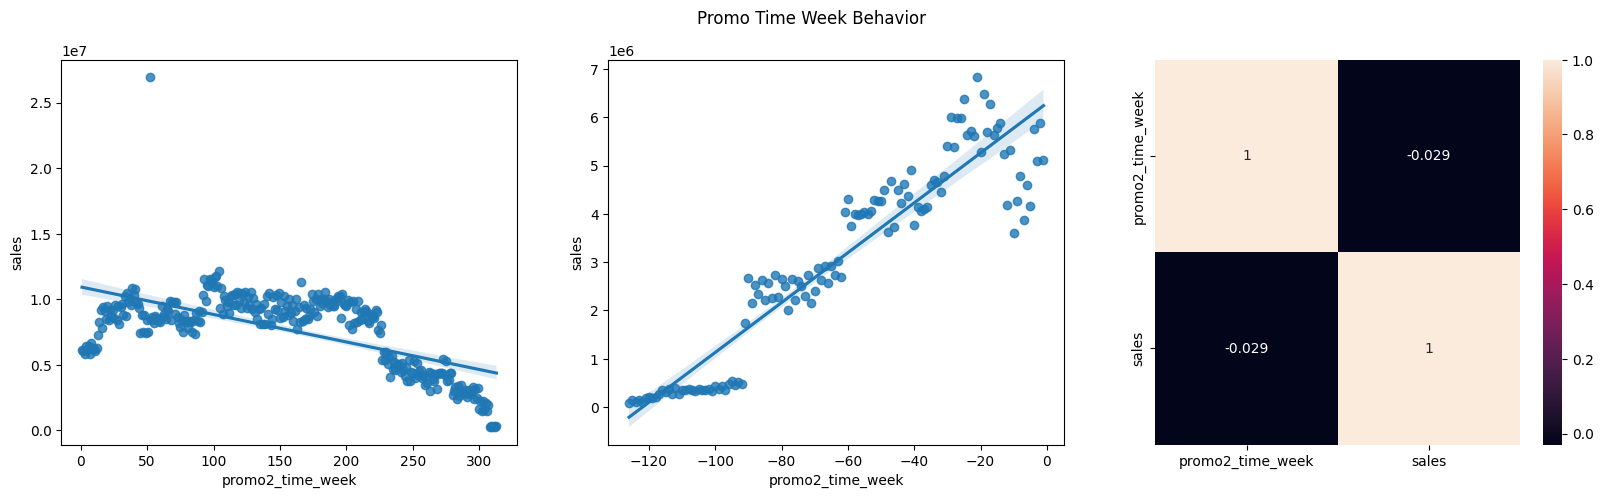

In [35]:
aux1 = df3[['promo2_time_week', 'sales']].groupby( 'promo2_time_week').sum().reset_index()
#sns.barplot( x='promo2_time_week', y='sales', data=aux1 );

# extended promo
aux2 = aux1[ aux1['promo2_time_week'] > 0 ] 

# regular promo
aux3 = aux1[ aux1['promo2_time_week'] < 0 ] 

fig, axes = plt.subplots(2, 1, figsize=(30, 10),  )
fig.suptitle('Promo Time Week Behavior')

axes[0].xaxis.set_tick_params( rotation=90 )
axes[1].xaxis.set_tick_params( rotation=90 )


sns.barplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.barplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Promo Time Week Behavior')

sns.regplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.regplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### <s> H5 - Lojas com mais dias de promoção deveriam vender mais (PRODUCT) </s>

**ON HOLD** Será necessária a criação de uma variável com a quantidade de dias em promoção. Fica para a próxima rodada do CRISP-DS

### H6 - Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)

**FALSA** Lojas com MAIS PROMOÇÔES CONSECUTIVAS vendem MENOS

**PROMO E PROMO2** aprensentam o mesmo comportamente em relação as vendas, portanto, ambas apresentam um correlação FRACA com a variável resposta

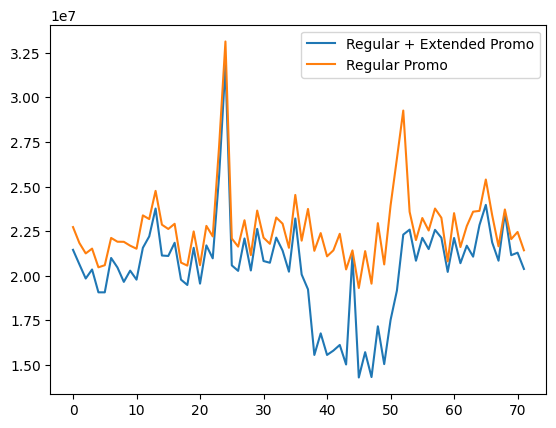

In [36]:
# regular and extended promo
aux1 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 1 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# regular promo
aux2 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 0 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular + Extended Promo', 'Regular Promo'] );

### H7 -  Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**FALSA**, Lojas abertas durante o feriado de Natal vendem MENOS

**STATE_HOLIDAY** possui comportamentos distintos entre os tipos de feriados e por isso ter uma correlação FORTE com a variável resposta

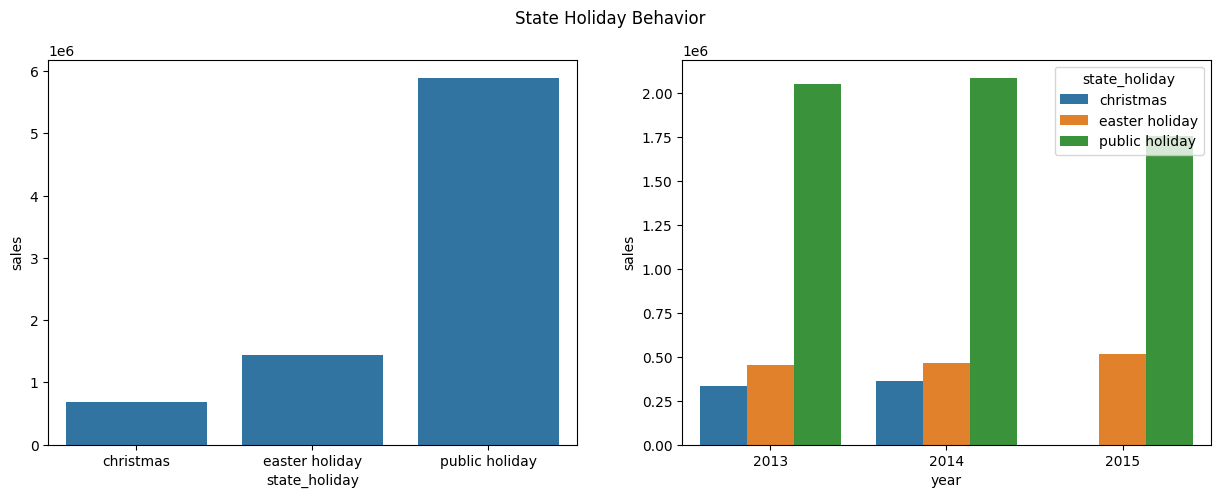

In [37]:
aux1 = df3[ df3['state_holiday'] != 'regular day'][['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
aux2 = df3[ df3['state_holiday'] != 'regular day'][['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5) )
fig.suptitle('State Holiday Behavior')

sns.barplot( x='state_holiday', y='sales', data=aux1, ax=axes[0] );
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2, ax=axes[1] );



### H8 - Lojas deveriam vender mais ao longo dos anos (TIME)

**FALSA** Lojas vendem MENOS ao longo dos anos

**YEAR** Possui uma correlação FORTE com a variável resposta

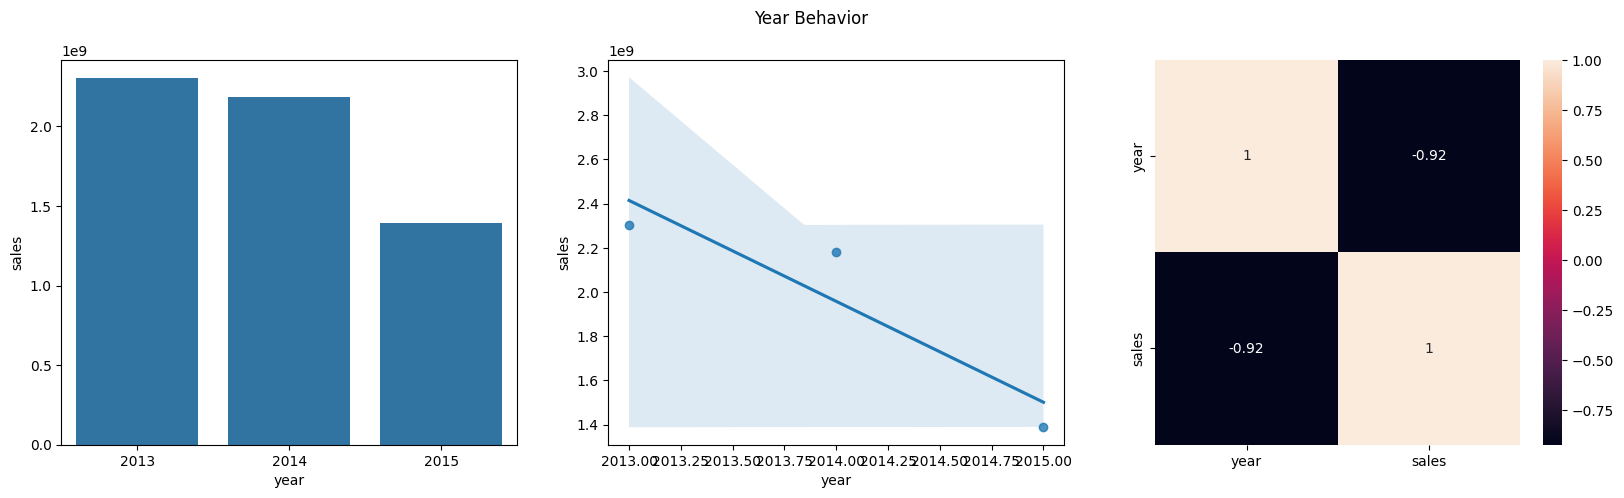

In [38]:
aux1 = df3[['year', 'sales']].groupby( 'year' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Year Behavior')

sns.barplot( x='year', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='year', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### H9 - Lojas deveriam vender mais no segundo semestre do ano (TIME)

**FALSA** Lojas vendem MENOS no segundo semestre do ANO

**MONTH** possui uma ALTA correlação com a variável resposta

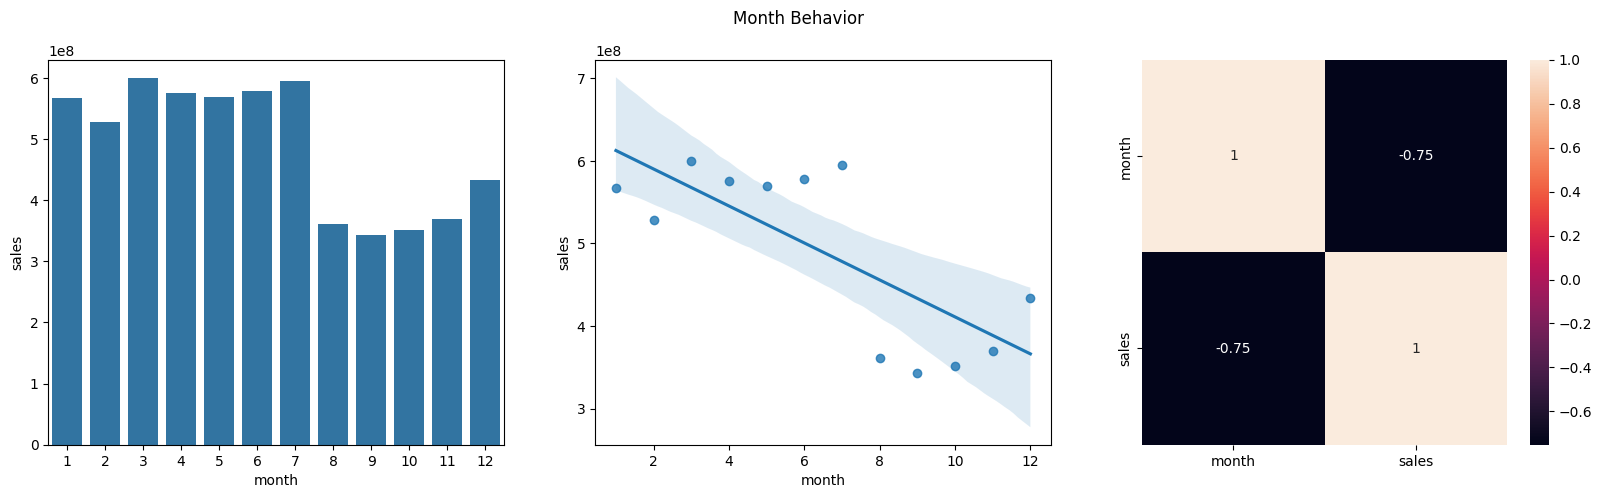

In [39]:
aux1 = df3[['month', 'sales']].groupby( 'month' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Month Behavior')

sns.barplot( x='month', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='month', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês

**DAY** possui uma correlação MÉDIA com a variável resposta

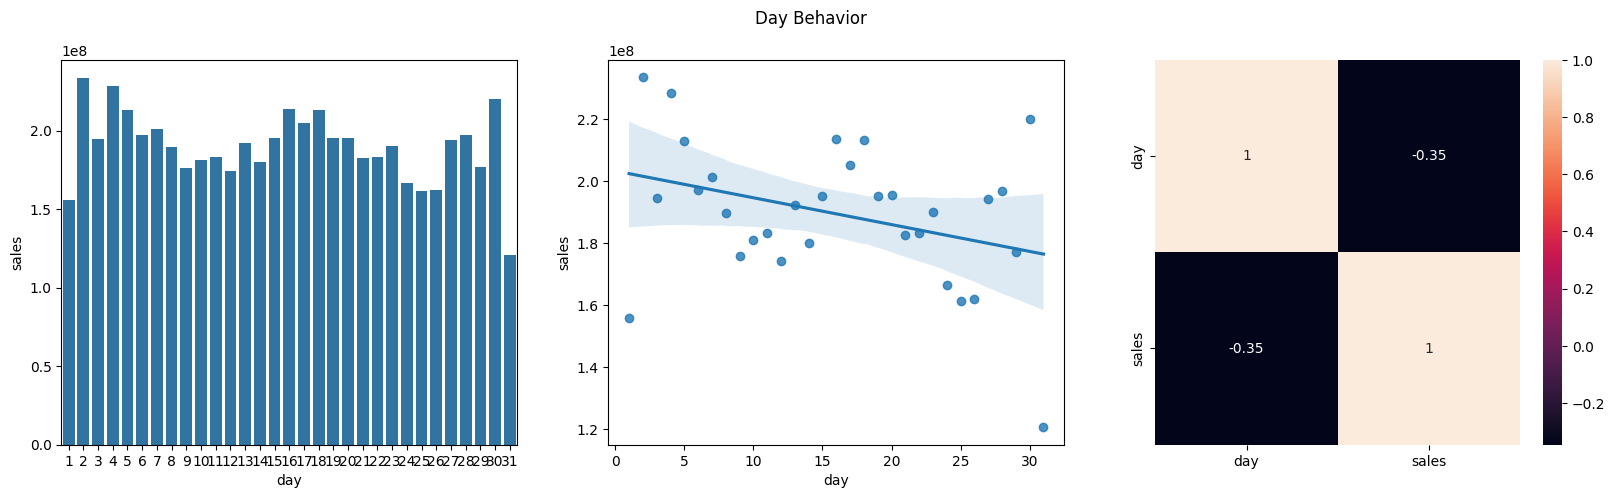

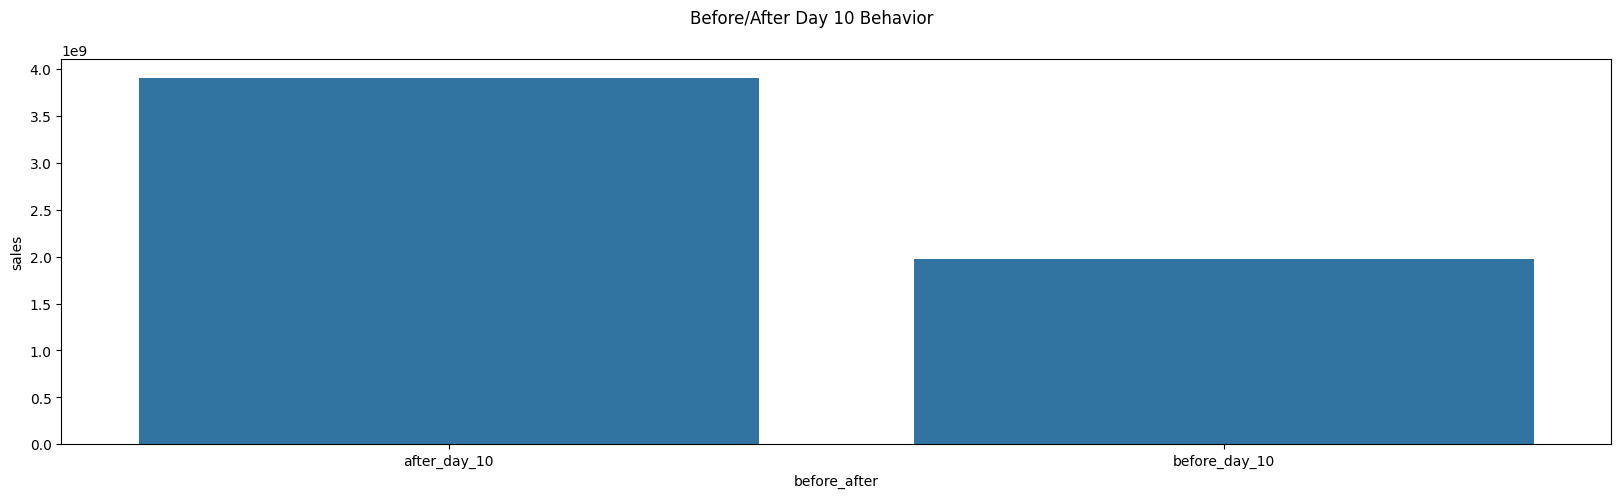

In [40]:
aux1 = df3[['day', 'sales']].groupby( 'day' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day Behavior')

sns.barplot( x='day', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Before/After Day 10 Behavior')

sns.barplot( x='before_after', y='sales', data=aux2 );

### H11 -  Lojas deveriam vender menos nos finais de semana (TIME)

**VERDADEIRA** Lojas vendem MENOS nos finais de semana

**DAY_OF_WEEK** possui uma correlação ALTA com a variável resposta

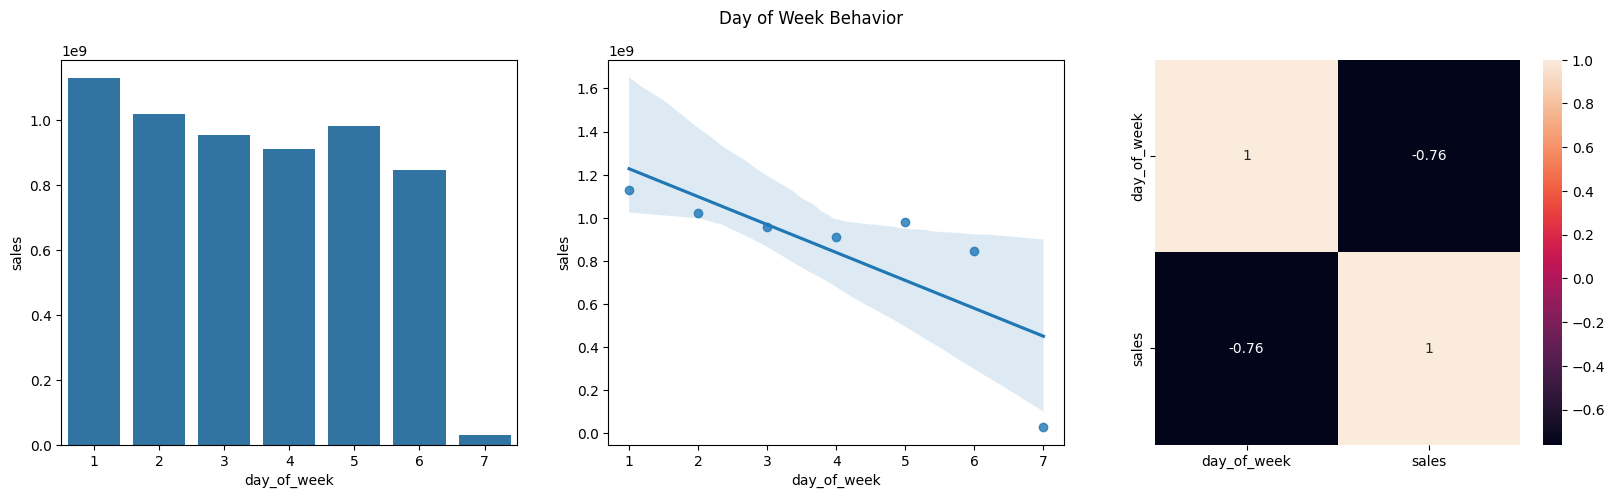

In [41]:
aux1 = df3[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day of Week Behavior')

sns.barplot( x='day_of_week', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day_of_week', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H12 - Lojas deveriam vender menos durante os feriados escolares (TIME)

**VERDADEIRA** Lojas vendem MENOS durante  os feriados escolares, exceto mês de agosto

**SCHOOL_HOLIDAY** possui uma correlação ALTA com a variável resposta, no entanto, possui pouca variação de comportamento

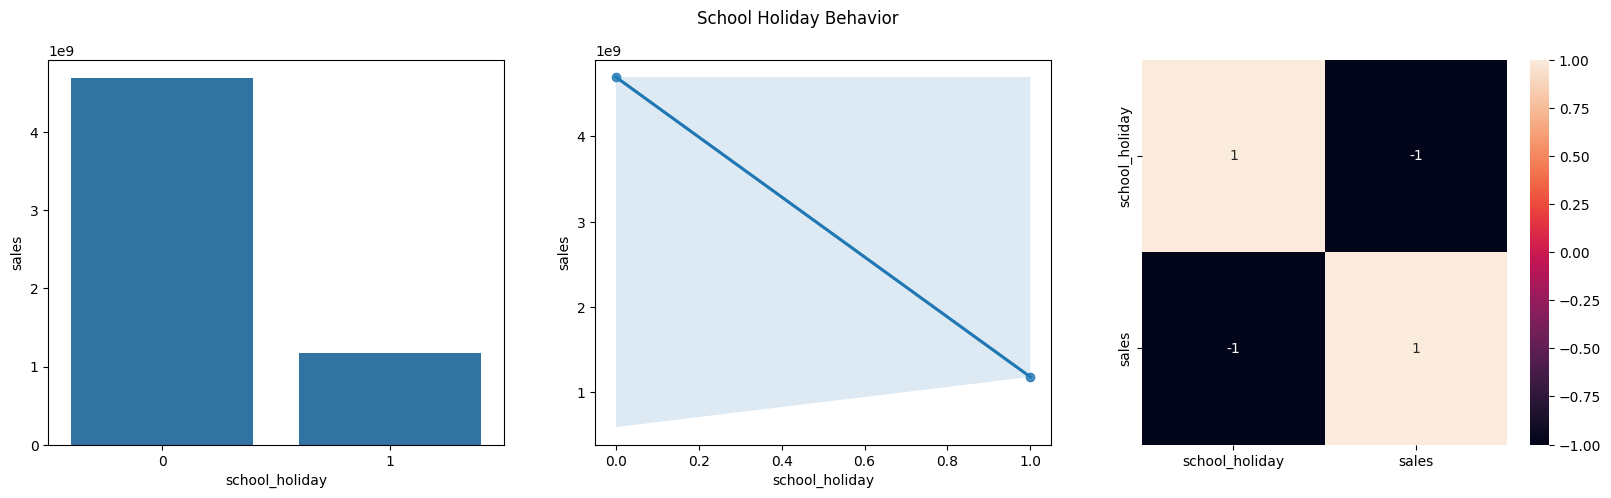

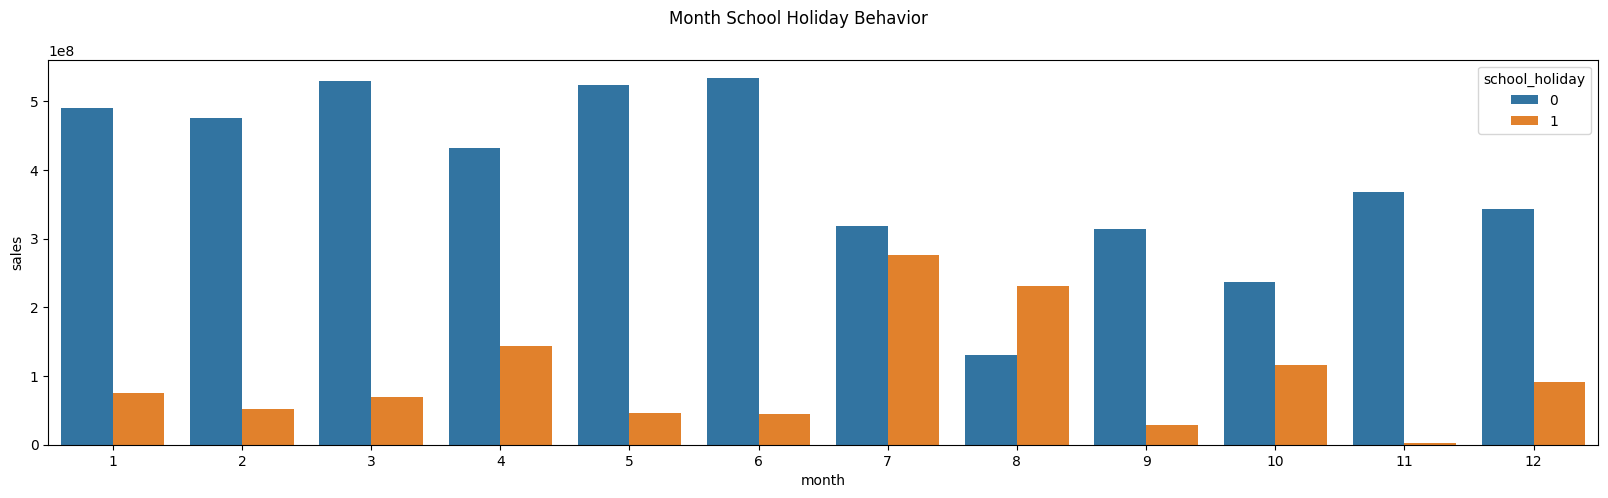

In [42]:
aux1 = df3[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('School Holiday Behavior')

sns.barplot( x='school_holiday', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='school_holiday', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


aux2 = df3[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Month School Holiday Behavior')

sns.barplot( x='month', hue='school_holiday', y='sales', data=aux2 );

### 3.2.1 Resumo das Hipóteses

In [43]:
tab = [ ['Hipóteses', 'Conclusão', 'Relevância'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Baixa'],
        ['H3', 'Falsa', 'Baixa'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Alta'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Média'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
]

print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Alta
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Média
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

<Axes: >

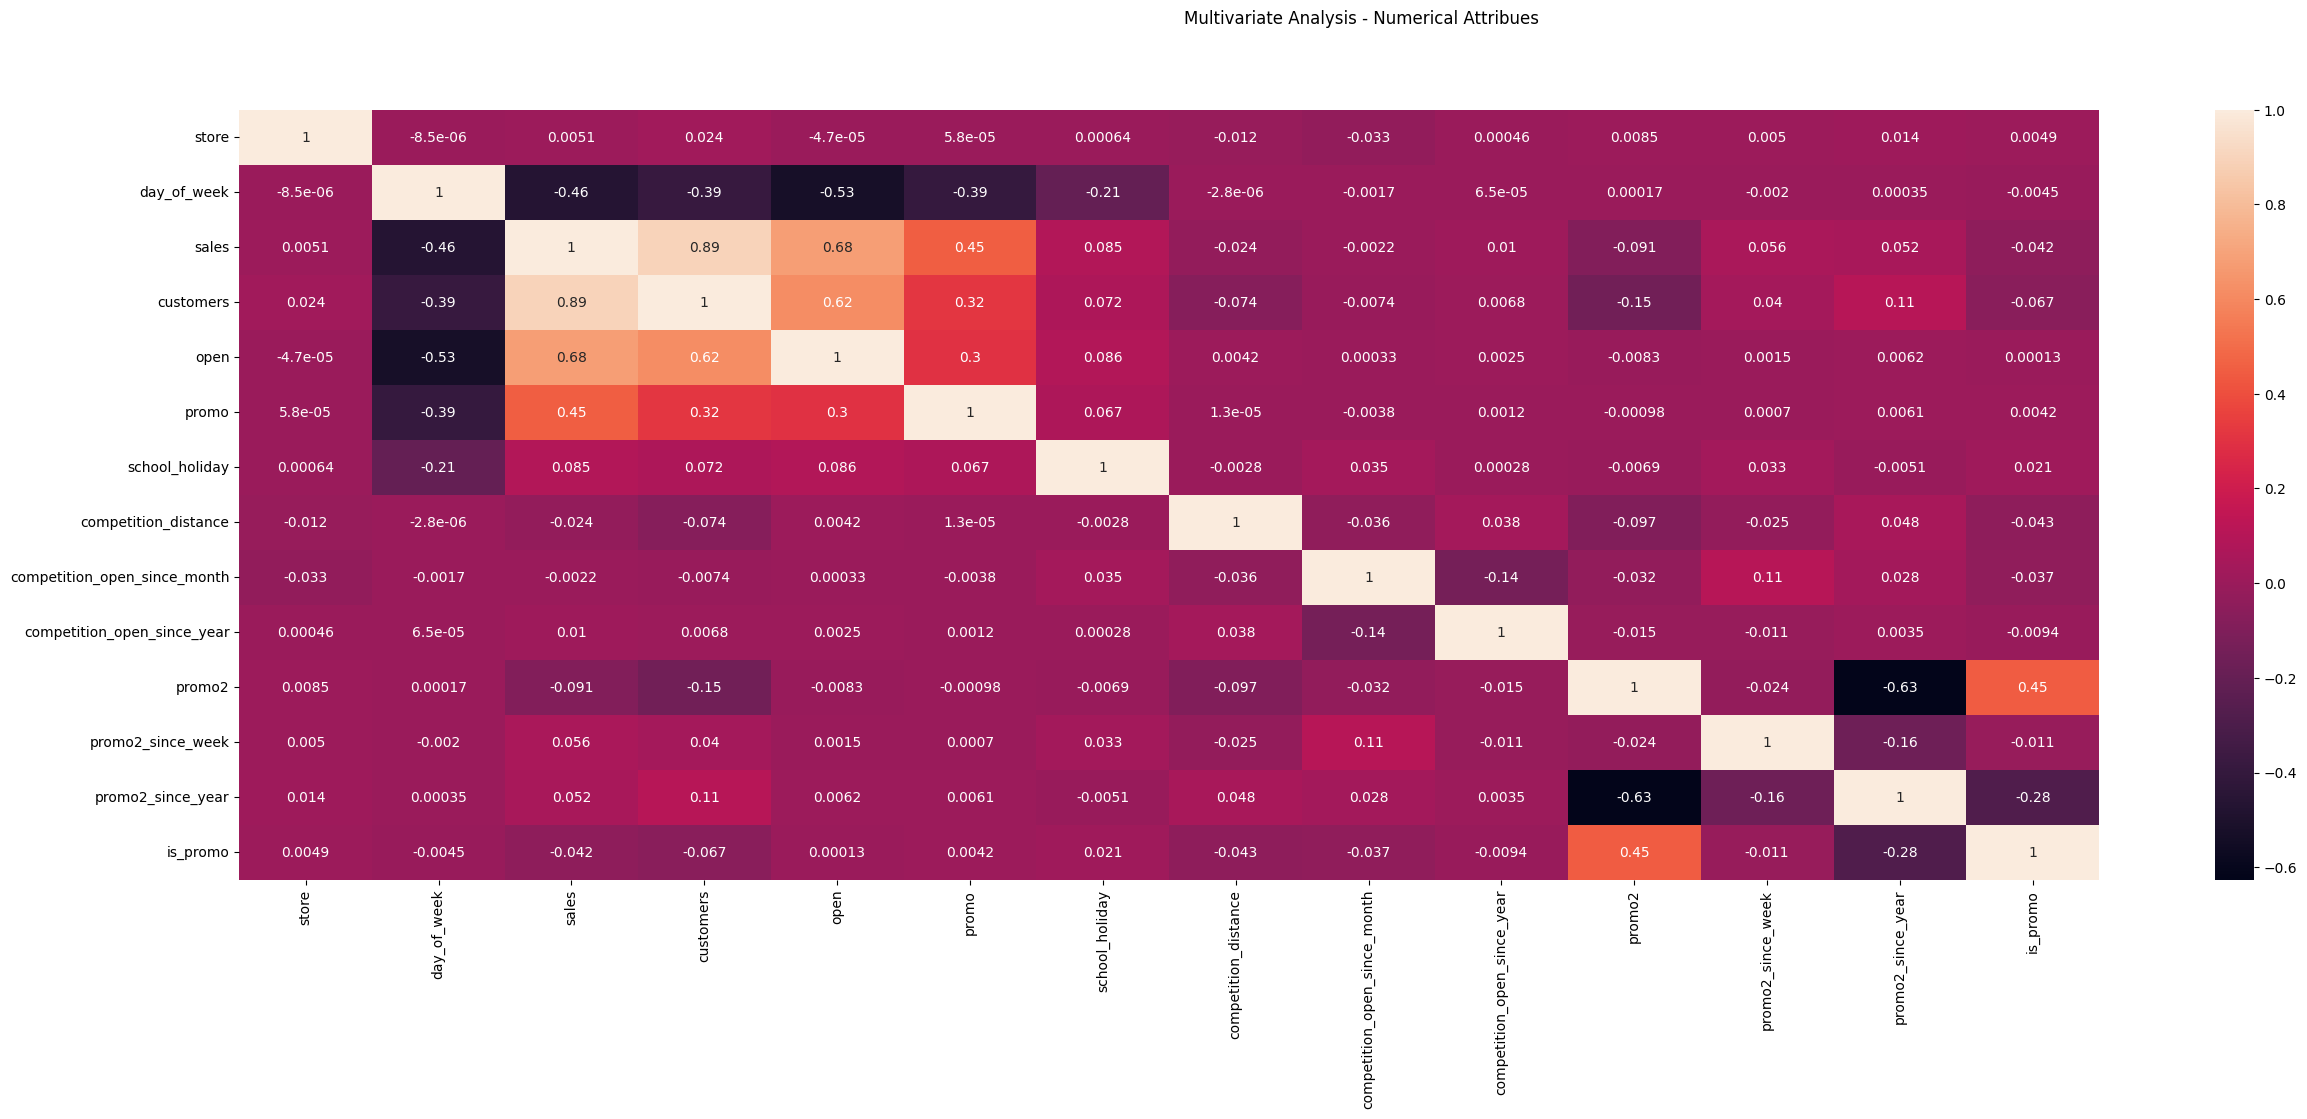

In [44]:
correlation = df_num_attributes.corr( method='pearson' )

fig, axes = plt.subplots(1, 1, figsize=(30, 10) )
fig.suptitle('Multivariate Analysis - Numerical Attribues ')

sns.heatmap( correlation, annot=True )

### 3.3.2 Categorical Attributes

In [45]:
# create a dataframe with new categorical columns
cat = df3.select_dtypes( include='object' )
cat.sample(5)


,state_holiday,store_type,assortment,year_week
587829,regular day,d,extended,2014-4
7835,regular day,d,extended,2015-30
736057,regular day,d,extended,2013-37
284389,regular day,c,basic,2014-46
19410,regular day,a,extended,2015-29


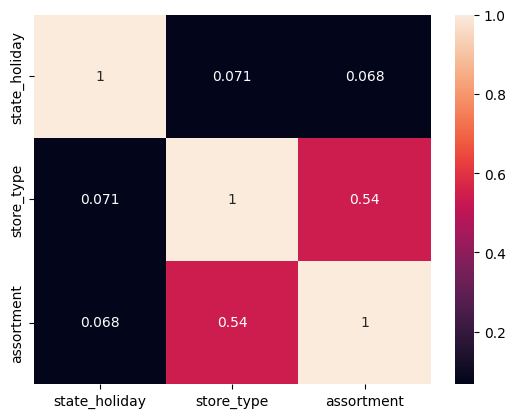

In [46]:
# calculate cramer´s v for all columns combinations 
cv1 = cramer_v( cat['state_holiday'], cat['state_holiday'] )
cv2 = cramer_v( cat['state_holiday'], cat['store_type'] )
cv3 = cramer_v( cat['state_holiday'], cat['assortment'] )

cv4 = cramer_v( cat['store_type'], cat['state_holiday'] )
cv5 = cramer_v( cat['store_type'], cat['store_type'] )
cv6 = cramer_v( cat['store_type'], cat['assortment'] )

cv7 = cramer_v( cat['assortment'], cat['state_holiday'] )
cv8 = cramer_v( cat['assortment'], cat['store_type'] )
cv9 = cramer_v( cat['assortment'], cat['assortment'] )

# create final dataframe
df = pd.DataFrame( { 'state_holiday' : [cv1, cv2, cv3],
                     'store_type'    : [cv4, cv5, cv6],
                     'assortment'    : [cv7, cv8, cv9],
                    })
df = df.set_index( df.columns )

# plot correlations between categorical attributes
sns.heatmap( df, annot=True);

# 4.0 Data Preparation

In [47]:
df4 = df3.copy()

## 4.1 Normalization Method

**COMENTÁRIO:** Ao observar a distribuição das variáveis numéricas (seção 3.1.2), nota-se que NÃO HÁ variáveis com distribuição NORMAL, portanto, não há sentido em executar o método de normalização nesse conjunto de dados

## 4.2 Rescaling Method

### 4.2.1 Min-Max Scaler

#### promo2_time_week

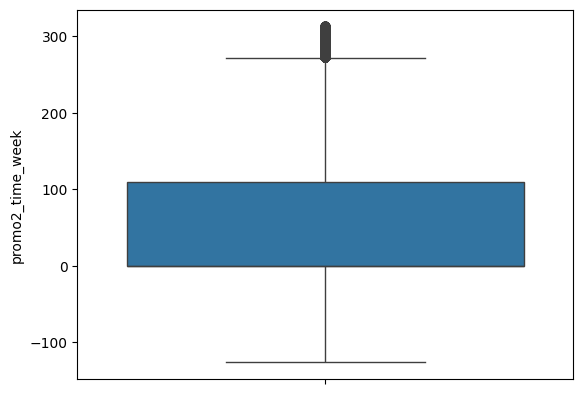

In [48]:
# Few outliers 
sns.boxplot( df4['promo2_time_week'] );

# Apply MinMaxScaler
mms = MinMaxScaler()
df4['promo2_time_week'] = mms.fit_transform( df4[['promo2_time_week']].values )

#### year column

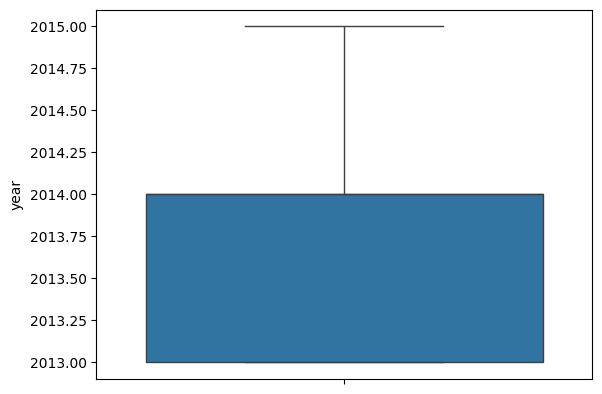

In [49]:
# Few outliers 
sns.boxplot( df4['year'] );

# Apply MinMaxScaler
mms = MinMaxScaler()
df4['year'] = mms.fit_transform( df4[['year']].values )

### 4.2.2 Robuster Scaler

#### competition_distance column

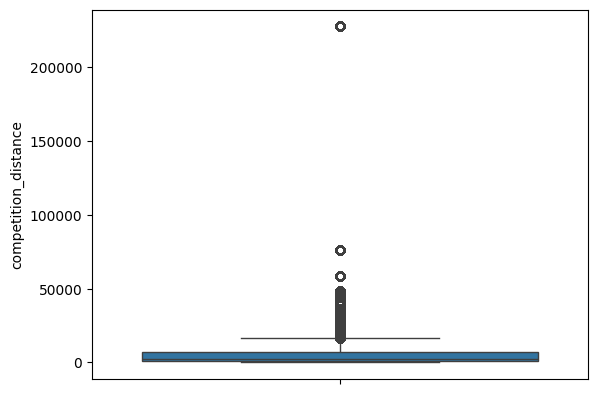

In [50]:
# Many outliers 
sns.boxplot( df4['competition_distance'] );

# Apply RobustScaler
rs = RobustScaler()
df4['competition_distance'] = rs.fit_transform( df4[['competition_distance']].values )


#### competition_time_month

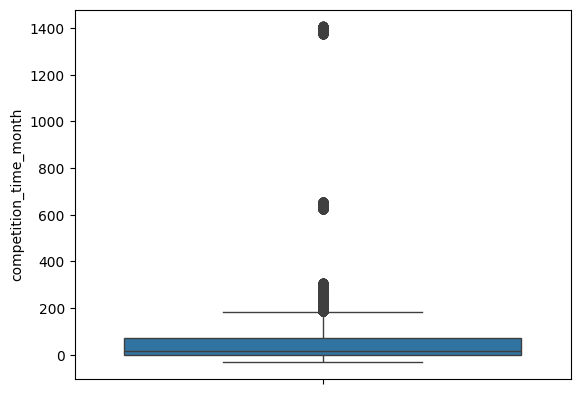

In [51]:
# Many outliers 
sns.boxplot( df4['competition_time_month'] );

# Apply RobustScaler
rs = RobustScaler()
df4['competition_time_month'] = rs.fit_transform( df4[['competition_time_month']].values )


## 4.3 Transformation Method

### 4.3.1 Encoding Transformation

#### state_holiday column

In [52]:
# Apply One-Hot Encoding
df4 = pd.get_dummies( df4, prefix=['state_holiday'], columns=['state_holiday'] )

df4.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter holiday,state_holiday_public holiday,state_holiday_regular day
308668,354,3,2014-10-15,5709,0,1,d,extended,-0.133871,10,...,42,2014-42,2005-10-01,1.270270,2014-10-13,0.287016,False,False,False,True
317648,1025,1,2014-10-06,9300,1,0,a,basic,-0.259677,11,...,41,2014-41,2009-11-01,0.594595,2014-10-06,0.287016,False,False,False,True
450923,134,5,2014-05-23,5271,1,0,a,basic,-0.182258,9,...,21,2014-21,2008-09-01,0.716216,2014-05-19,0.287016,False,False,False,True
106925,1001,1,2015-04-27,9106,1,0,c,basic,2.791935,4,...,18,2015-18,2015-04-01,-0.216216,2011-03-28,0.772210,False,False,False,True
466081,797,6,2014-05-10,4127,0,0,a,basic,-0.038710,10,...,19,2014-19,2012-10-01,0.040541,2014-09-29,0.239180,False,False,False,True


#### store_type column

In [53]:
# Apply Label Encoding
le = LabelEncoder()
df4['store_type'] = le.fit_transform( df4['store_type'])

df4.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter holiday,state_holiday_public holiday,state_holiday_regular day
166373,239,3,2015-03-04,5922,1,0,3,extended,-0.277419,3,...,10,2015-10,2015-03-01,-0.216216,2015-03-02,0.287016,False,False,False,True
355994,1037,2,2014-08-26,4311,0,0,0,extended,-0.351613,8,...,35,2014-35,2014-08-01,-0.216216,2014-08-25,0.287016,False,False,False,True
602456,27,2,2014-01-07,15092,1,1,0,basic,-0.366129,1,...,2,2014-2,2005-01-01,1.256757,2011-01-24,0.637813,False,False,False,True
26373,729,3,2015-07-08,8607,0,1,2,extended,1.072581,6,...,28,2015-28,2011-06-01,0.445946,2015-07-06,0.287016,False,False,False,True
556600,1001,2,2014-02-18,6118,1,1,2,basic,2.791935,2,...,8,2014-8,2014-02-01,-0.216216,2011-03-28,0.630979,False,False,False,True


#### assortment column

In [54]:
# Apply Ordinal Encoding
assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
df4['assortment'] = df4['assortment'].map( assortment_dict )

df4.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter holiday,state_holiday_public holiday,state_holiday_regular day
641415,1076,3,2013-12-04,3882,1,0,0,3,-0.361290,12,...,49,2013-49,2013-12-01,-0.216216,2012-12-31,0.396355,False,False,False,True
571726,517,2,2014-02-04,7619,1,0,0,3,3.251613,2,...,6,2014-6,2014-02-01,-0.216216,2014-02-03,0.287016,False,False,False,True
376624,1110,1,2014-08-04,7026,1,1,2,3,-0.230645,9,...,32,2014-32,2010-09-01,0.418919,2014-08-04,0.287016,False,False,False,True
421983,184,3,2014-06-18,8141,1,0,3,3,0.198387,6,...,25,2014-25,2014-06-01,-0.216216,2014-06-16,0.287016,False,False,False,True
821459,490,2,2013-06-25,6722,0,0,0,1,-0.269355,4,...,26,2013-26,2013-04-01,-0.189189,2014-09-29,0.136674,False,False,False,True


### 4.3.2 Response Variable Transformation

In [55]:
# Apply Logarithm Transformation
df4['sales'] = np.log1p( df4['sales'] ) 

### 4.3.3 Nature Transformation - Variables with cyclic behavior

#### month column

In [56]:
# Calculate sin and cos 
df4['month_sin'] = df4['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
df4['month_cos'] = df4['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

df4[['month', 'month_sin', 'month_cos']].sample(5)

,month,month_sin,month_cos
612328,12,-2.449294e-16,1.000000e+00
192402,2,8.660254e-01,5.000000e-01
981347,2,8.660254e-01,5.000000e-01
770798,8,-8.660254e-01,-5.000000e-01
347075,9,-1.000000e+00,-1.836970e-16


#### day_of_week column

In [57]:
# Calculate sin and cos 
df4['day_of_week_sin'] = df4['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
df4['day_of_week_cos'] = df4['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )

df4[['day_of_week', 'day_of_week_sin', 'day_of_week_cos']].sample(5)

,day_of_week,day_of_week_sin,day_of_week_cos
771852,5,-0.974928,-0.222521
1014258,4,-0.433884,-0.900969
799174,1,0.781831,0.623490
640176,4,-0.433884,-0.900969
446536,2,0.974928,-0.222521


#### day column

In [58]:
# Calculate sin and cos 
df4['day_sin'] = df4['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
df4['day_cos'] = df4['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

df4[['day', 'day_sin', 'day_cos']].sample(5)

,day,day_sin,day_cos
96593,6,0.951057,0.309017
567566,8,0.994522,-0.104528
718292,26,-0.743145,0.669131
665940,12,0.587785,-0.809017
321915,1,0.207912,0.978148


#### week_of_year column

In [59]:
# Calculate sin and cos 
df4['week_of_year_sin'] = df4['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
df4['week_of_year_cos'] = df4['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )

df4[['week_of_year', 'week_of_year_sin', 'week_of_year_cos']].sample(5)

,week_of_year,week_of_year_sin,week_of_year_cos
721067,39,-1.000000,-1.836970e-16
88094,20,0.663123,-7.485107e-01
303523,43,-0.885456,4.647232e-01
424896,25,0.120537,-9.927089e-01
182607,8,0.822984,5.680647e-01


# 5.0 Feature Selection

In [60]:
df5 = df4.copy()

## 5.1 Split Dataframe into trainning and test Dataset

In [61]:
# remove all features that created new features
cols_drop = ['week_of_year', 'month', 'day', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']
df5 = df5.drop( cols_drop, axis=1 )
df5.sample(5)

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public holiday,state_holiday_regular day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
960405,61,2013-02-20,8.269757,1,0,0,3,-0.319355,12,2007,...,False,True,8.660254e-01,0.500000,0.433884,-0.900969,-0.866025,-0.500000,0.822984,0.568065
5501,1042,2015-07-27,8.454253,1,1,0,1,0.179032,7,2015,...,False,True,-5.000000e-01,-0.866025,0.781831,0.623490,-0.587785,0.809017,-0.568065,-0.822984
437740,331,2014-06-04,8.933664,1,0,0,3,-0.267742,6,2014,...,False,True,1.224647e-16,-1.000000,0.433884,-0.900969,0.743145,0.669131,0.354605,-0.935016
180456,942,2015-02-20,8.856091,1,0,3,3,0.730645,2,2015,...,False,True,8.660254e-01,0.500000,-0.974928,-0.222521,-0.866025,-0.500000,0.822984,0.568065
981060,646,2013-02-02,8.377931,0,0,0,1,-0.275806,9,2014,...,False,True,8.660254e-01,0.500000,-0.781831,0.623490,0.406737,0.913545,0.568065,0.822984


In [62]:
# calculate period - last 6 weeks
last_date  = df5[['store', 'date']].groupby( 'store' ).max().reset_index().loc[0, 'date']
first_date = last_date - datetime.timedelta( days=6*7 )

# create training dataset 
X_train = df5[ df5['date'] < first_date]
y_train = X_train['sales']

# create test dataset 
X_test = df5[ df5['date'] >= first_date]
y_test = X_test['sales']

# print dataset´s Min/Max Date
print(f'Training Min Date: { X_train["date"].min() }' )
print(f'Training Max Date: { X_train["date"].max() }' )

print(f'Test Min Date: { X_test["date"].min() }' )
print(f'Test Max Date: { X_test["date"].max() }' )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 5.2 Boruta as Feature Selector

In [63]:
# transform training and test as array values to fit Boruta
X_train_array = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_array = y_train.values.ravel()

# define Random Forest Regressor
# rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_array, y_train_array )

## 5.3 Selected and NOT Selected Features by Boruta

In [64]:
# get cols selected and not selected by boruta
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )

# best features
# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [65]:
# features selected by boruta
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo2_time_week', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_cos']
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [66]:
# features NOT selected by boruta
cols_not_selected_boruta = ['is_promo', 'month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter holiday',
                            'state_holiday_public holiday', 'state_holiday_regular day', 'week_of_year_sin', 'year']
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter holiday',
 'state_holiday_public holiday',
 'state_holiday_regular day',
 'week_of_year_sin',
 'year']

# 5.4 Final Feature Selection by Me and Boruta

In [67]:
final_features = cols_selected_boruta + ['month_sin', 'week_of_year_sin'] 
final_features

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'month_sin',
 'week_of_year_sin']

In [68]:
# add date and sales columns to cols_selected_boruta
# cols_selected_boruta.extend( ['date', 'sales'] )
# cols_selected_boruta

# 6.0 Machine Learning Modelling

In [69]:
# create 2 new dataframes with features final list 
x_train = X_train[final_features]
x_test  = X_test[final_features]

## 6.1 Average Model

In [70]:
# create aux_df with database test + response variable (sales)
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales' :  'sales_predictions' } )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_avg = aux1['sales_predictions']

# calculate performance with response variable "sales" on original scale 
avg_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_avg ) )
avg_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 6.2 Linear Regression Model

In [71]:
# define model
lr_model = LinearRegression().fit( x_train, y_train )

# create predictions
yhat_lr = lr_model.predict( x_test )

# calculate performance
lr_model_result = ml_error( 'Linear Regression Model', np.expm1( y_test ), np.expm1( yhat_lr) )
lr_model_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,1866.540564,0.292612,2671.143586


## 6.3 Linear Regression Regularized Model - Lasso

In [72]:
# define model
lasso_model = Lasso( alpha=0.01 ).fit( x_train, y_train )

# create predictions
yhat_lasso = lasso_model.predict( x_test )

# calculate performance
lasso_model_result = ml_error( 'Linear Regression Regularized Model - Lasso', np.expm1( y_test ), np.expm1( yhat_lasso) )
lasso_model_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized Model - Lasso,1891.443724,0.289079,2744.531123


## 6.4 Random Forest Regressor

In [73]:
# define model
rf_model = RandomForestRegressor( n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# create predictions
yhat_rf = rf_model.predict( x_test )

# calculate performance
rf_model_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf) )
rf_model_result

: 

## 6.5 XGBoost Regressor

In [ ]:
# define model
xgb_model = xgb.XGBRegressor( objetive='reg:squarederror', 
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10,  
                              sub_sample=0.7,
                              colsample_bytee=0.9).fit( x_train, y_train )

# create predictions
yhat_xgb = xgb_model.predict( x_test )

# calculate performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb) )
xgb_result